In [1]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import cv2
import numpy as np
from PIL import Image
from darknet import darknet
import csv
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet
from misc.color import get_rgb
from misc.utils import blend_transparent, area_inside
from shapely.geometry import Polygon, box
warnings.filterwarnings('ignore')
import pandas
from io import BytesIO
import PIL
from PIL import Image as Img
from IPython.display import display, Image
import glob
from os.path import join
import json
import pandas

In [2]:
os.chdir( '/data/demo/Annotation')

In [3]:
annotation = 'data.csv'
images = 'JPEGImages/AnnotationImagesSeabirds/*.jpg'

Reading and analyzing the given annotation file.

In [5]:
p=pandas.read_csv(annotation, sep='^([^,]+),', header=0, usecols=['image name', 'annotation data'])
p

image name  \
0     Farallon3_20190501_000001_No002.jpg   
1     Farallon3_20190501_000001_No003.jpg   
2     Farallon3_20190501_021546_No001.jpg   
3     Farallon3_20190501_021546_No002.jpg   
4     Farallon3_20190501_043129_No002.jpg   
5     Farallon3_20190501_043129_No003.jpg   
6     Farallon3_20190501_064715_No001.jpg   
7     Farallon3_20190501_064715_No002.jpg   
8     Farallon3_20190501_064715_No003.jpg   
9     Farallon3_20190501_064715_No004.jpg   
10    Farallon3_20190501_064715_No005.jpg   
11    Farallon3_20190501_090300_No001.jpg   
12    Farallon3_20190501_090300_No004.jpg   
13    Farallon3_20190501_090300_No005.jpg   
14    Farallon3_20190501_111845_No003.jpg   
15    Farallon3_20190501_111845_No005.jpg   
16    Farallon3_20190501_133429_No001.jpg   
17    Farallon3_20190501_133429_No005.jpg   
18    Farallon3_20190501_155012_No002.jpg   
19    Farallon3_20190501_155012_No003.jpg   
20    Farallon3_20190501_155012_No005.jpg   
21    Farallon3_20190501_180556_No003.jpg   
22    Farallon3_20190501_180556_No004.jpg   
23    Farallon3_20190501_180556_No005.jpg   
24    Farallon3_20190501_202140_No001.jpg   
25    Farallon3_20190501_202140_No005.jpg   
26    Farallon3_20190501_223725_No001.jpg   
27    Farallon3_20190501_223725_No003.jpg   
28    Farallon3_20190502_000002_No001.jpg   
29    Farallon3_20190502_000002_No002.jpg   
...                                   ...   
2273            Rost3_20190509_120407.jpg   
2274            Rost3_20190516_035604.jpg   
2275            Rost3_20190516_061149.jpg   
2276            Rost3_20190516_074303.jpg   
2277            Rost3_20190516_082733.jpg   
2278            Rost3_20190516_095845.jpg   
2279            Rost3_20190516_121430.jpg   
2280            Rost3_20190516_125901.jpg   
2281            Rost3_20190516_143014.jpg   
2282            Rost3_20190516_151446.jpg   
2283            Rost3_20190516_164557.jpg   
2284            Rost3_20190517_070448.jpg   
2285            Rost3_20190517_083559.jpg   
2286            Rost3_20190517_092028.jpg   
2287            Rost3_20190517_105441.jpg   
2288            Rost3_20190517_113613.jpg   
2289            Rost3_20190706_000000.jpg   
2290            Rost3_20190706_043127.jpg   
2291            Rost3_20190706_064710.jpg   
2292            Rost3_20190706_090254.jpg   
2293            Rost3_20190706_112030.jpg   
2294            Rost3_20190706_155159.jpg   
2295            Rost3_20190706_180743.jpg   
2296            Rost3_20190706_202329.jpg   
2297        Rost3_20190706_202329_No2.jpg   
2298        Rost3_20190706_202329_No3.jpg   
2299        Rost3_20190706_202329_No4.jpg   
2300        Rost3_20190706_202329_No5.jpg   
2301        Rost3_20190706_223911_No1.jpg   
2302        Rost3_20190706_223911_No2.jpg   

                                        annotation data  
0                                       {"objects": []}  
1                                       {"objects": []}  
2                                       {"objects": []}  
3                                       {"objects": []}  
4     {"objects": [{"type": "AdultBird", "boundaries...  
5     {"objects": [{"type": "AdultBird", "boundaries...  
6     {"objects": [{"type": "AdultBird", "boundaries...  
7     {"objects": [{"type": "AdultBird", "boundaries...  
8     {"objects": [{"type": "AdultBird", "boundaries...  
9     {"objects": [{"type": "AdultBird", "boundaries...  
10    {"objects": [{"type": "AdultBird", "boundaries...  
11    {"objects": [{"type": "AdultBird", "boundaries...  
12    {"objects": [{"type": "AdultBird", "boundaries...  
13    {"objects": [{"type": "AdultBird", "boundaries...  
14    {"objects": [{"type": "AdultBird", "boundaries...  
15    {"objects": [{"type": "AdultBird", "boundaries...  
16    {"objects": [{"type": "AdultBird", "boundaries...  
17    {"objects": [{"type": "AdultBird", "boundaries...  
18    {"objects": [{"type": "AdultBird", "boundaries...  
19    {"objects": [{"type": "AdultBird", "boundaries...  
20    {"objects": [{"t

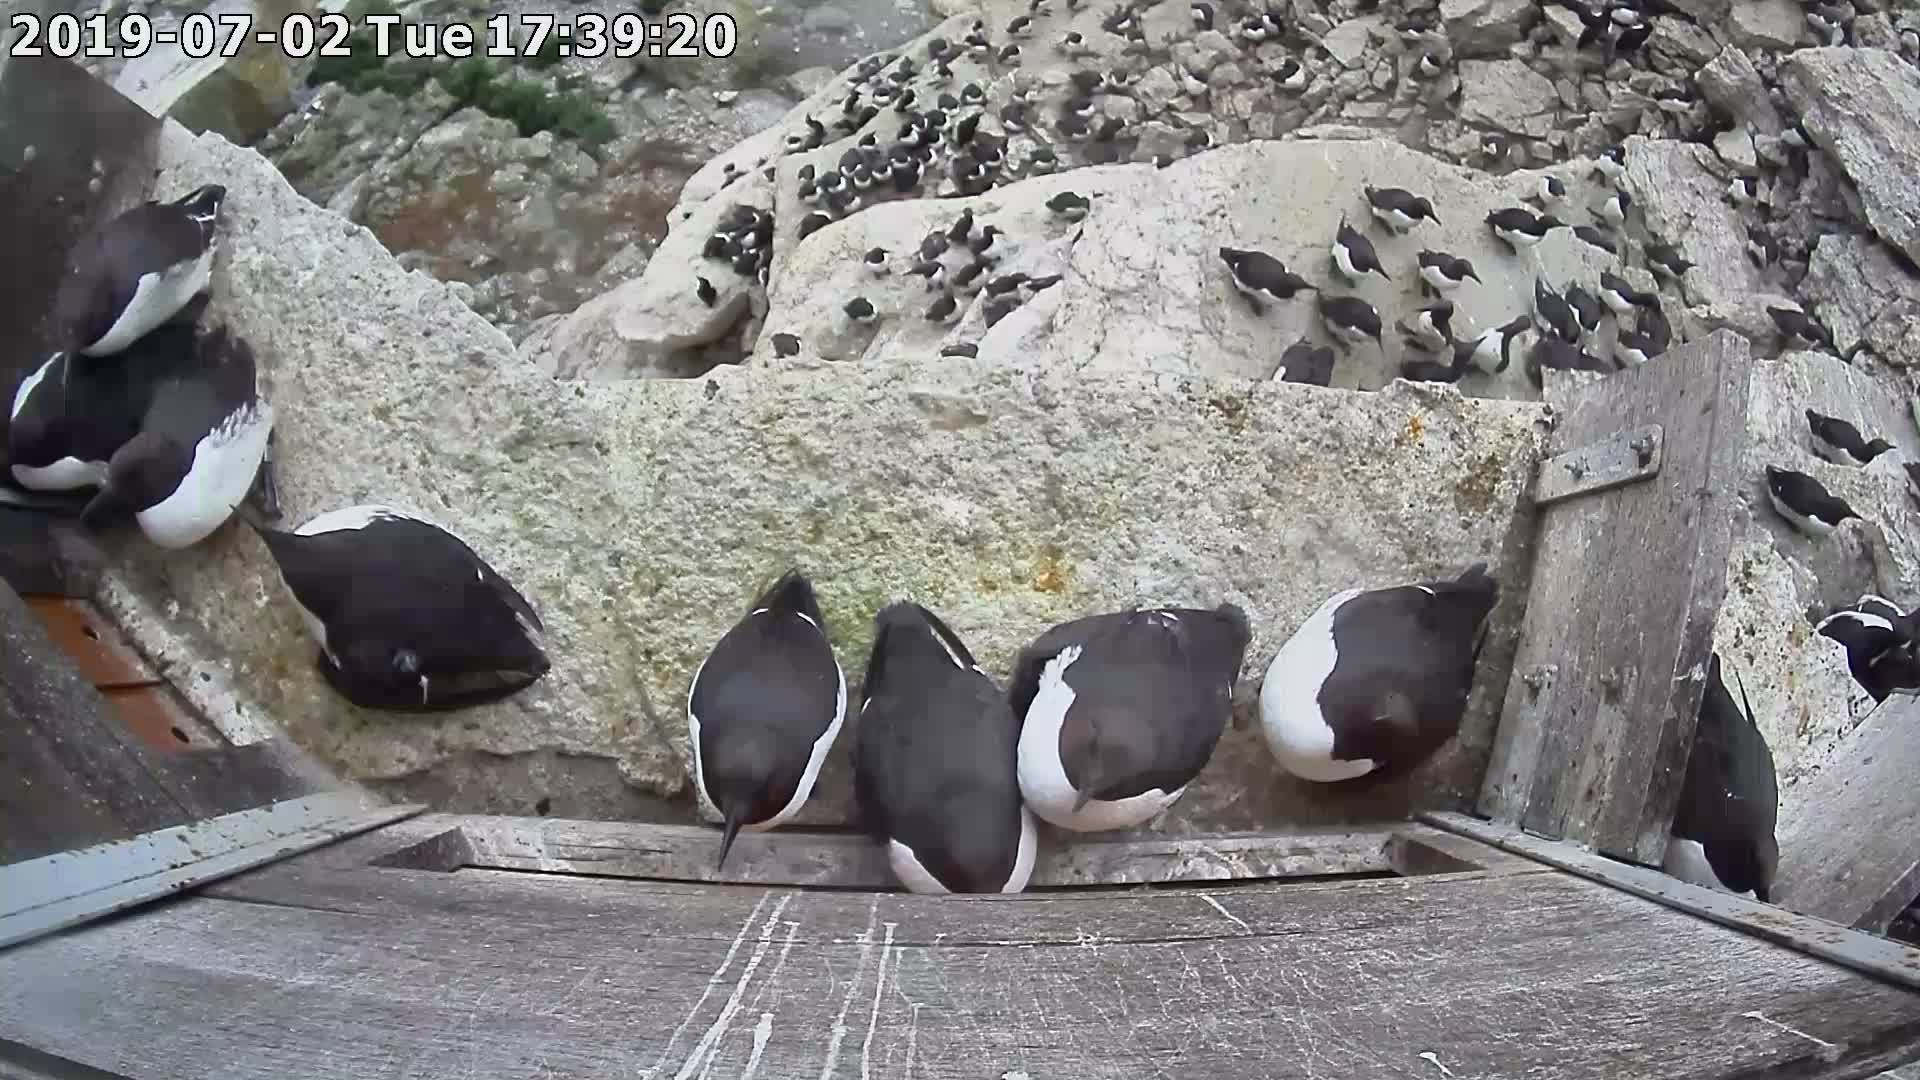

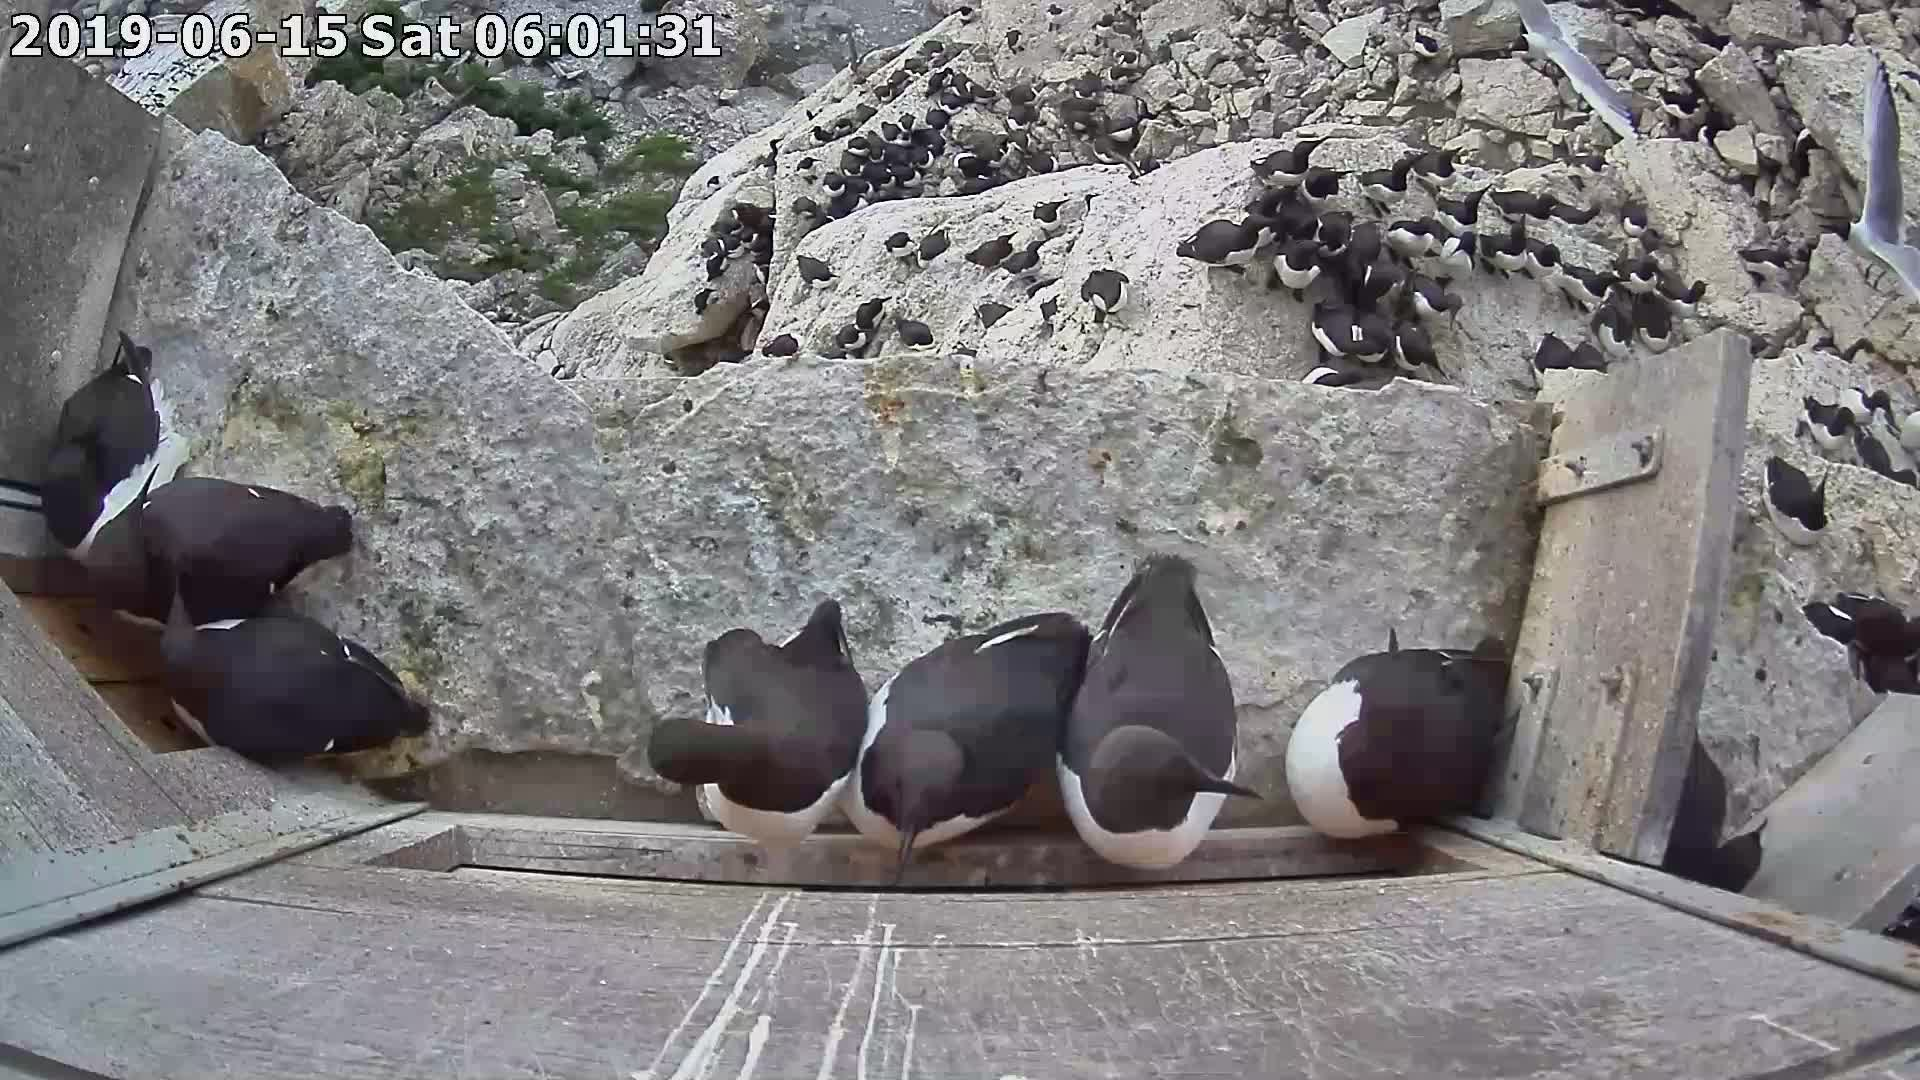

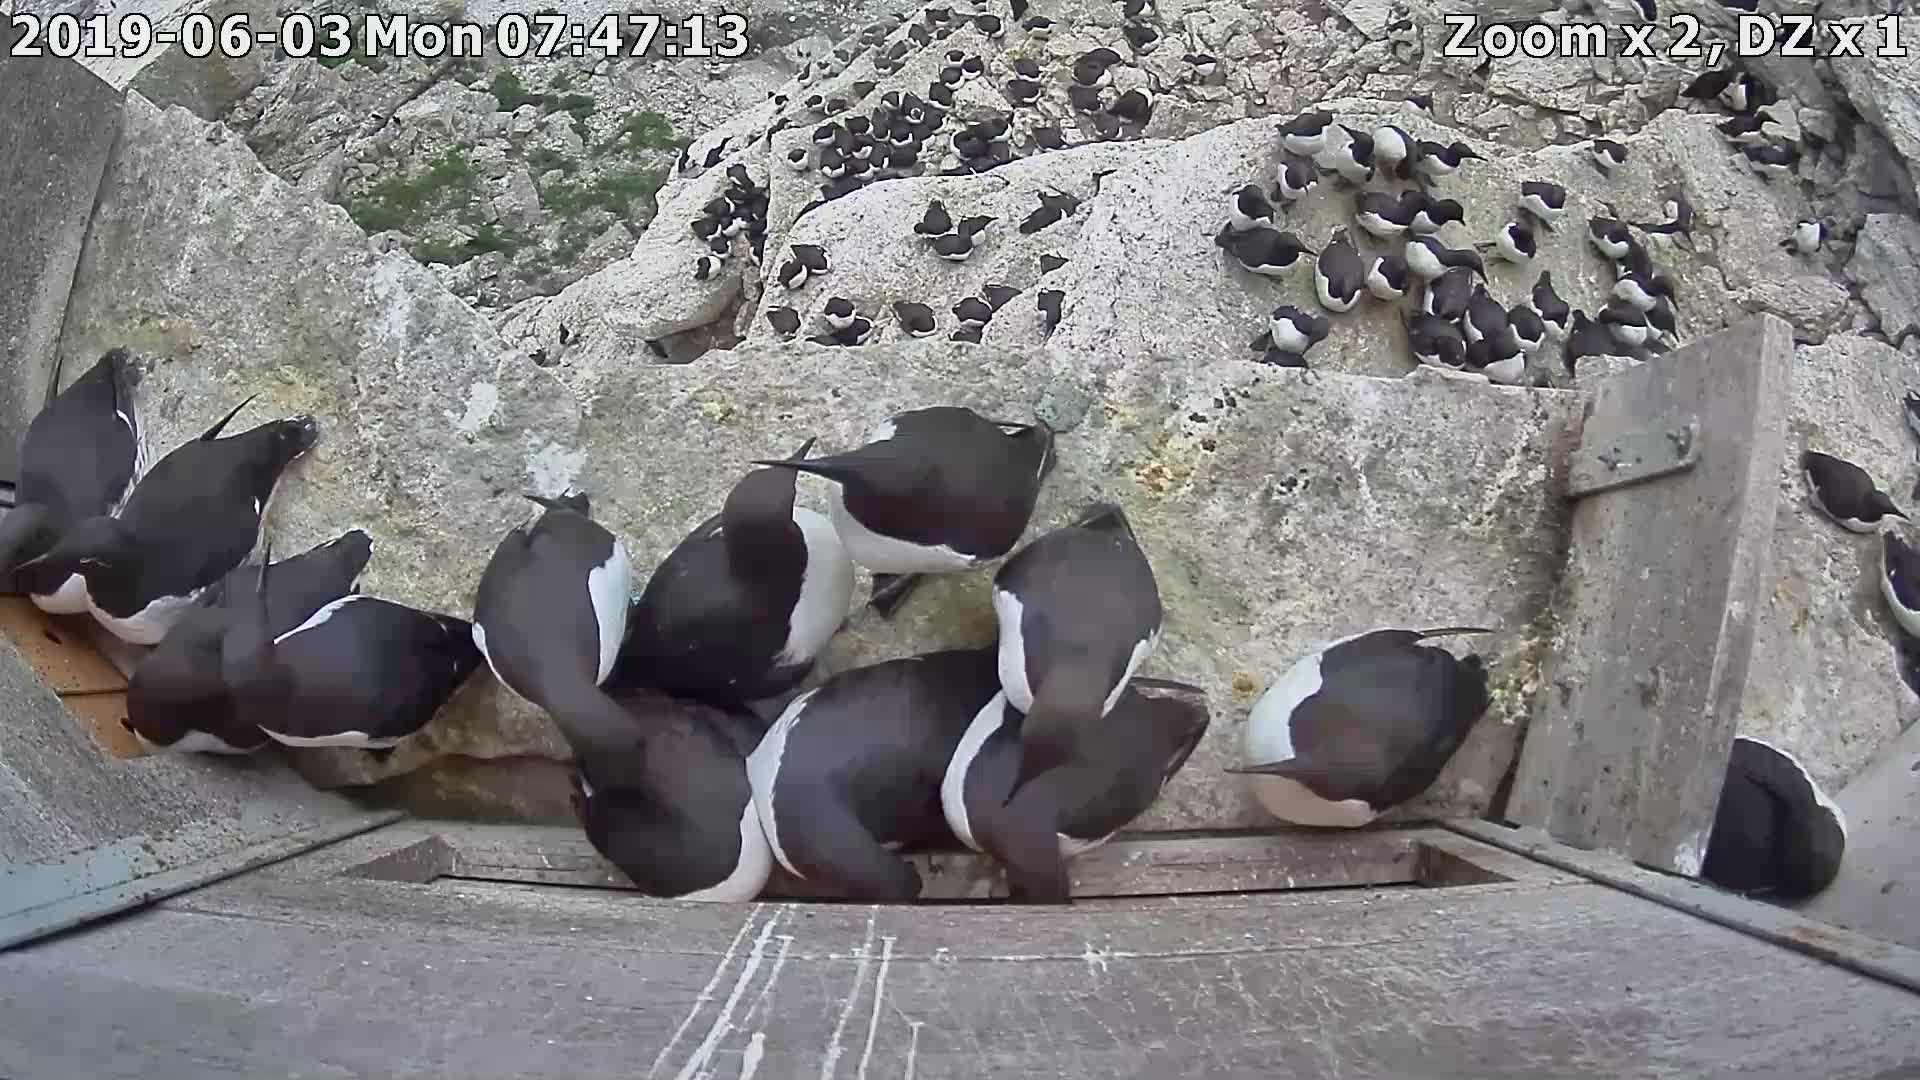

In [6]:
imgs = glob.glob(images)
for image in imgs[27:30]:
    display(Image(filename=image, width=600, height=400))
    

In [7]:
classes = ["AdultBird","Chick","Egg"]

# Width and height of the image 
w = 1920
h = 1080

In [8]:
def convert_annotation(a, image_id,size):
    image = image_name.split('.')[0]
    out_file = open("labels/%s.txt" %(image),'w')
    objects = a['objects']
    for obj in objects:
        cls = obj['type']
        cls_id = classes.index(cls)
        
        if len(obj['boundaries'])==0:
           continue
        m = obj['boundaries'][0]
        for p in m['boundaryPoints']:
           loc=p['edge'].rstrip('\n')
           if loc ==  "Bottom":
                x_b,y_b = p['coords']
           elif loc ==  "Top":
                x_t,y_t = p['coords']
           elif loc == "Right":
                x_r,y_r = p['coords']
           elif loc ==  "Left":
                x_l,y_l = p['coords']
                
        no_of_dets[cls] = no_of_dets[cls]+1
        #convert to yolo annotation
        dw = 1./size[0]
        dh = 1./size[1]
        x = (x_r + x_l)/2.0
        y = (y_t + y_b)/2.0
        x =  x*dw
        w = (x_r-x_l)*dw
        y = y*dh
        h = (y_t-y_b)*dh
        bb = (x,y,w,h)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')
    out_file.close()

In [9]:
list_file = open("/data/demo/Annotation/dataset.txt",'w')
count = 0
no_of_dets = {'AdultBird':0,'Chick':0,'Egg':0}
# traverse through each line
for index, row in p.iterrows():
    #print(row['c1'], row['c2'])
    #if "annotation" in line:
    #    continue
    #image_name = line.split(',',1)[0].strip()
    #annotation = line.split(',',1)[1].strip()
    image_name = row['image name'].strip()
    annotation = row['annotation data'].strip()
    image_file = "JPEGImages/AnnotationImagesSeabirds/"+ image_name +'\n'
    if os.path.exists(image_file.strip()):
        list_file.write(image_file)
    else:
        count=count+1
        #print(str(count) +"  " +image_file.strip())

    annotation = annotation.replace('\\"',"\"")
    jstr = json.loads(annotation)
    convert_annotation(jstr, image_name,[w,h])
    
list_file.close()

In [10]:
def check_annotation(file,label, dw,dh):
    label_data = open(label)
    im = cv2.imread(file)
    for line in label_data:
        x=float(line.split(' ')[1])*dw
        y=float(line.split(' ')[2])*dh
        w=float(line.split(' ')[3])*dw
        h=float(line.split(' ')[4])*dh
        out = cv2.rectangle(im, (int(x-w/2),int(y-h/2)) ,(int(x+w/2),int(y+h/2)), (0,0,255), 2)
    display(Img.fromarray(out))


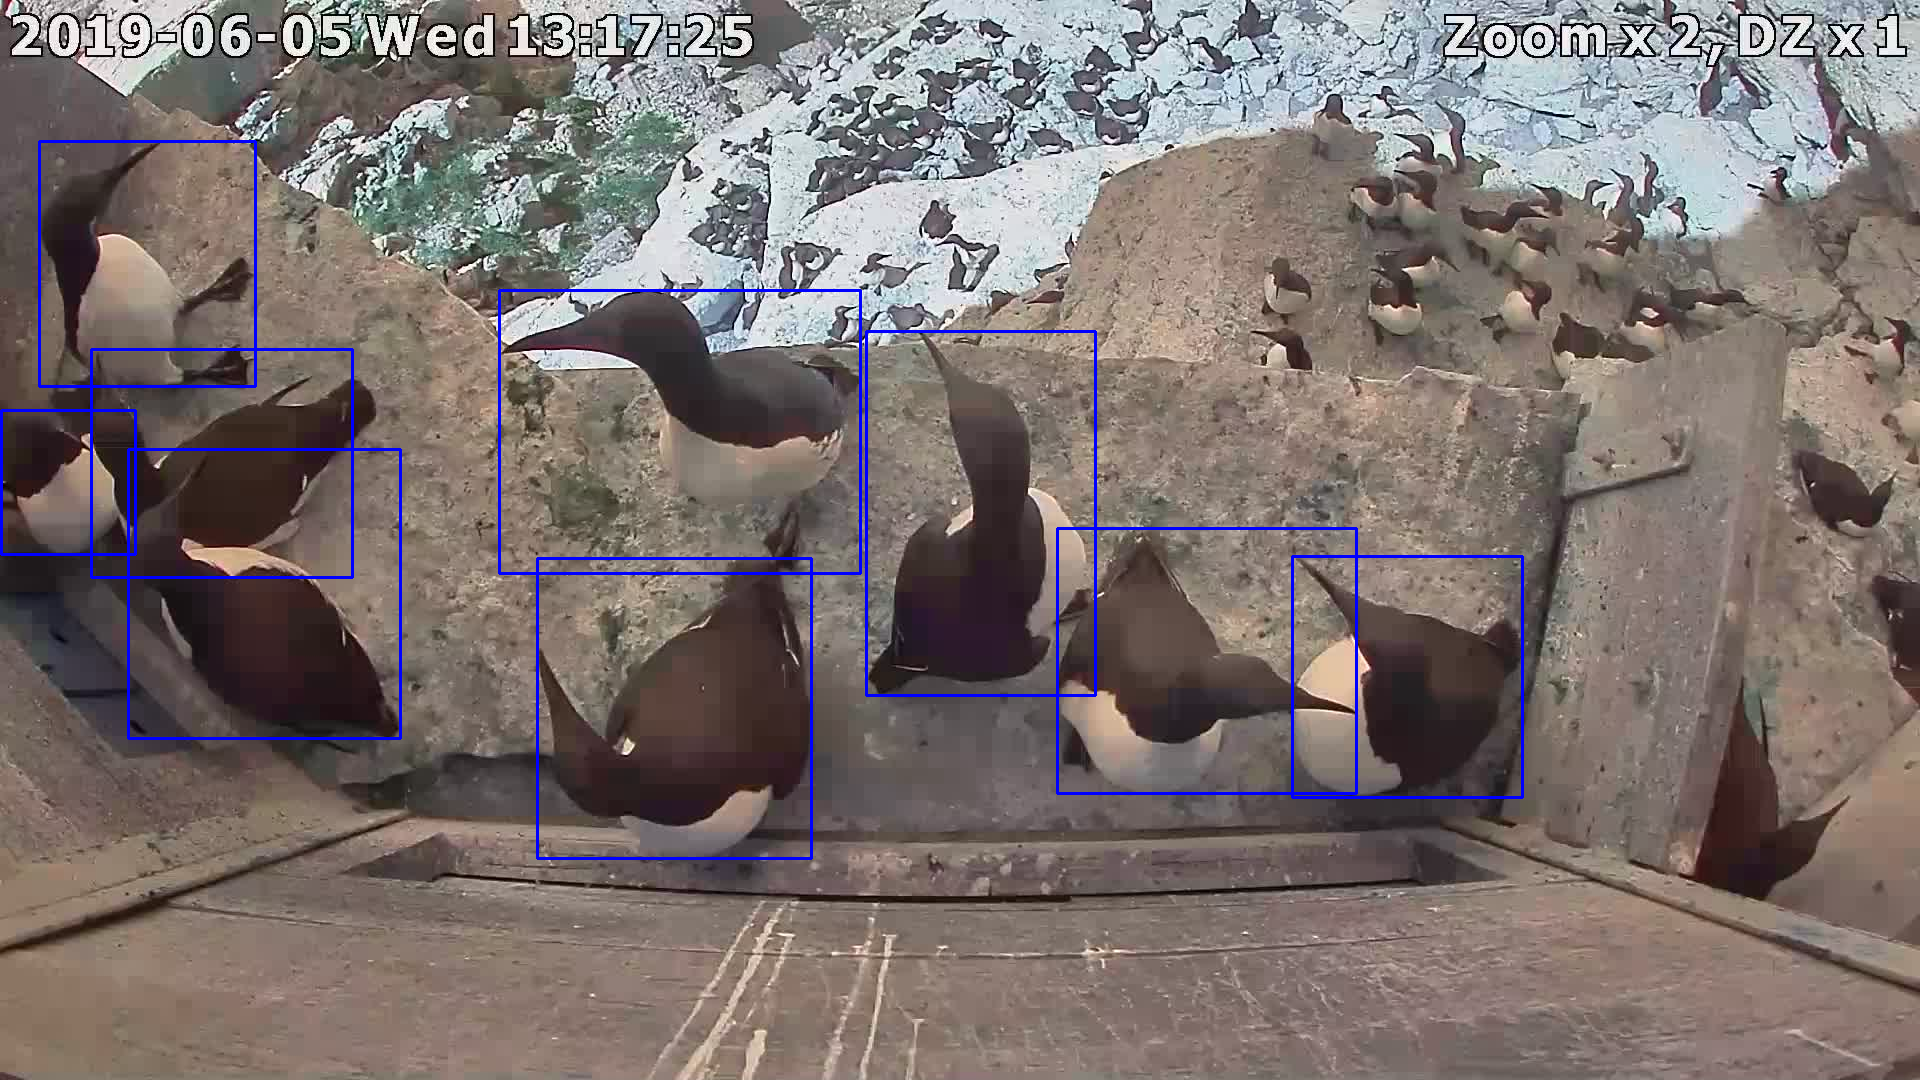

In [11]:
check_annotation('/data/demo/Annotation/JPEGImages/AnnotationImagesSeabirds/Farallon3_20190605_124725_No002.jpg','/data/demo/Annotation/labels/Farallon3_20190605_124725_No002.txt',1920,1080)

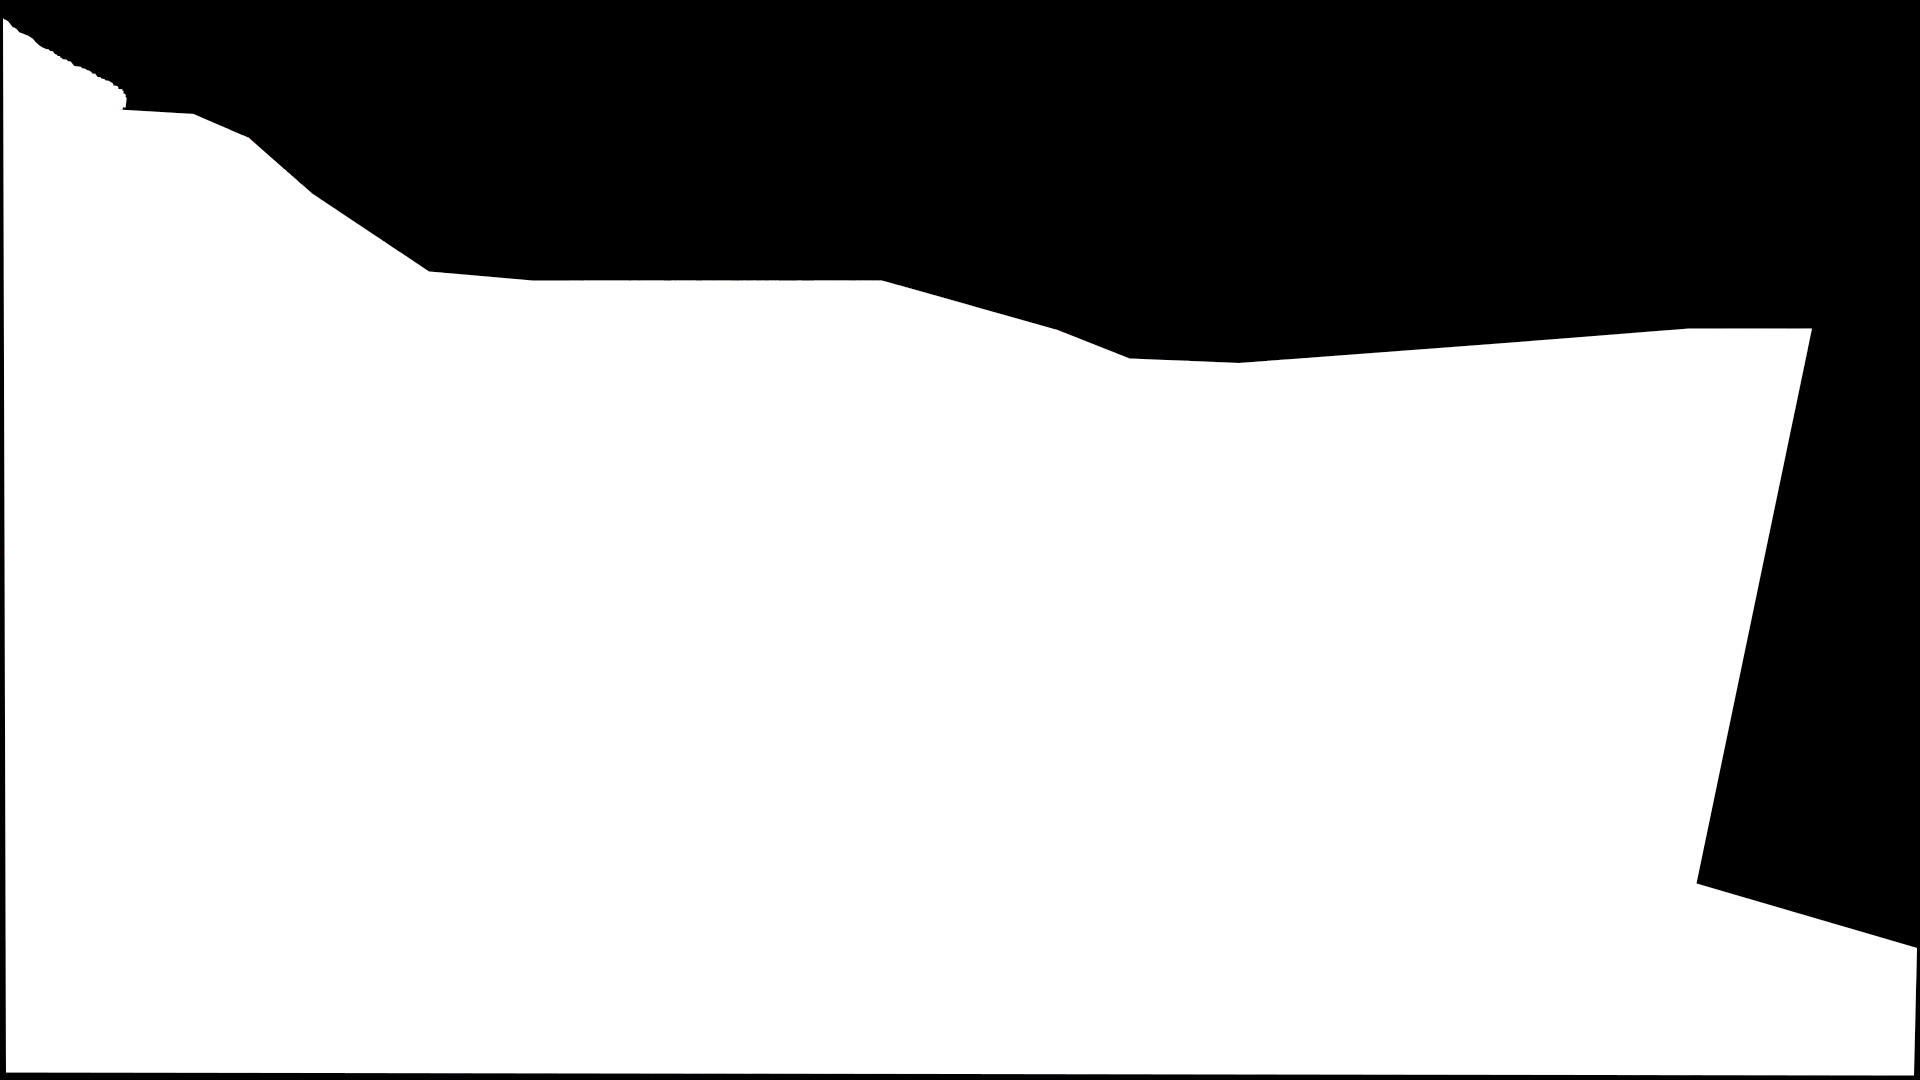

In [12]:
display(Image('/data/demo/Annotation/mask.jpg', width=600, height=480))

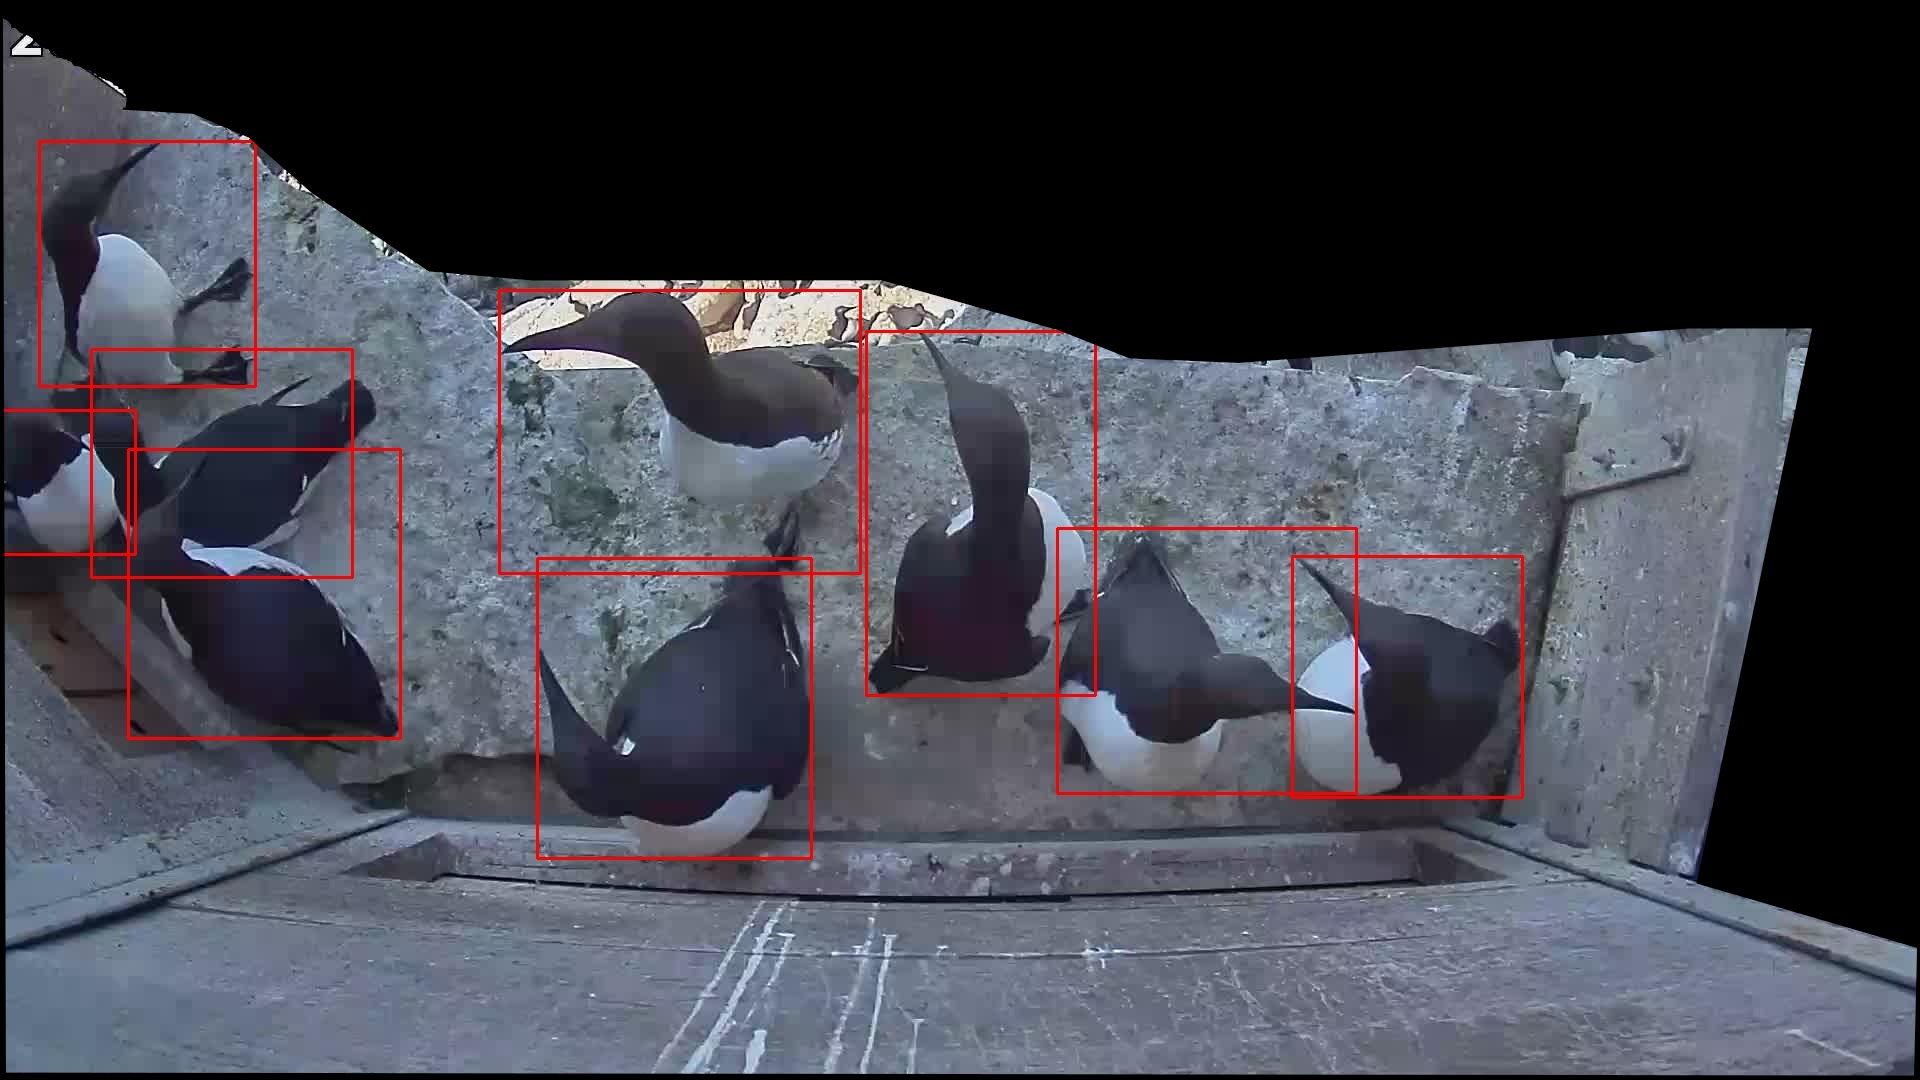

In [13]:
display(Image('/data/demo/Annotation/masked_image.jpg', width=600, height=480))

In [14]:
no_of_dets

{'AdultBird': 17919, 'Chick': 1021, 'Egg': 125}

1. Explore data augmentation techniques to decrease the class imbalance problem
2. Split the dataset into train and test sets

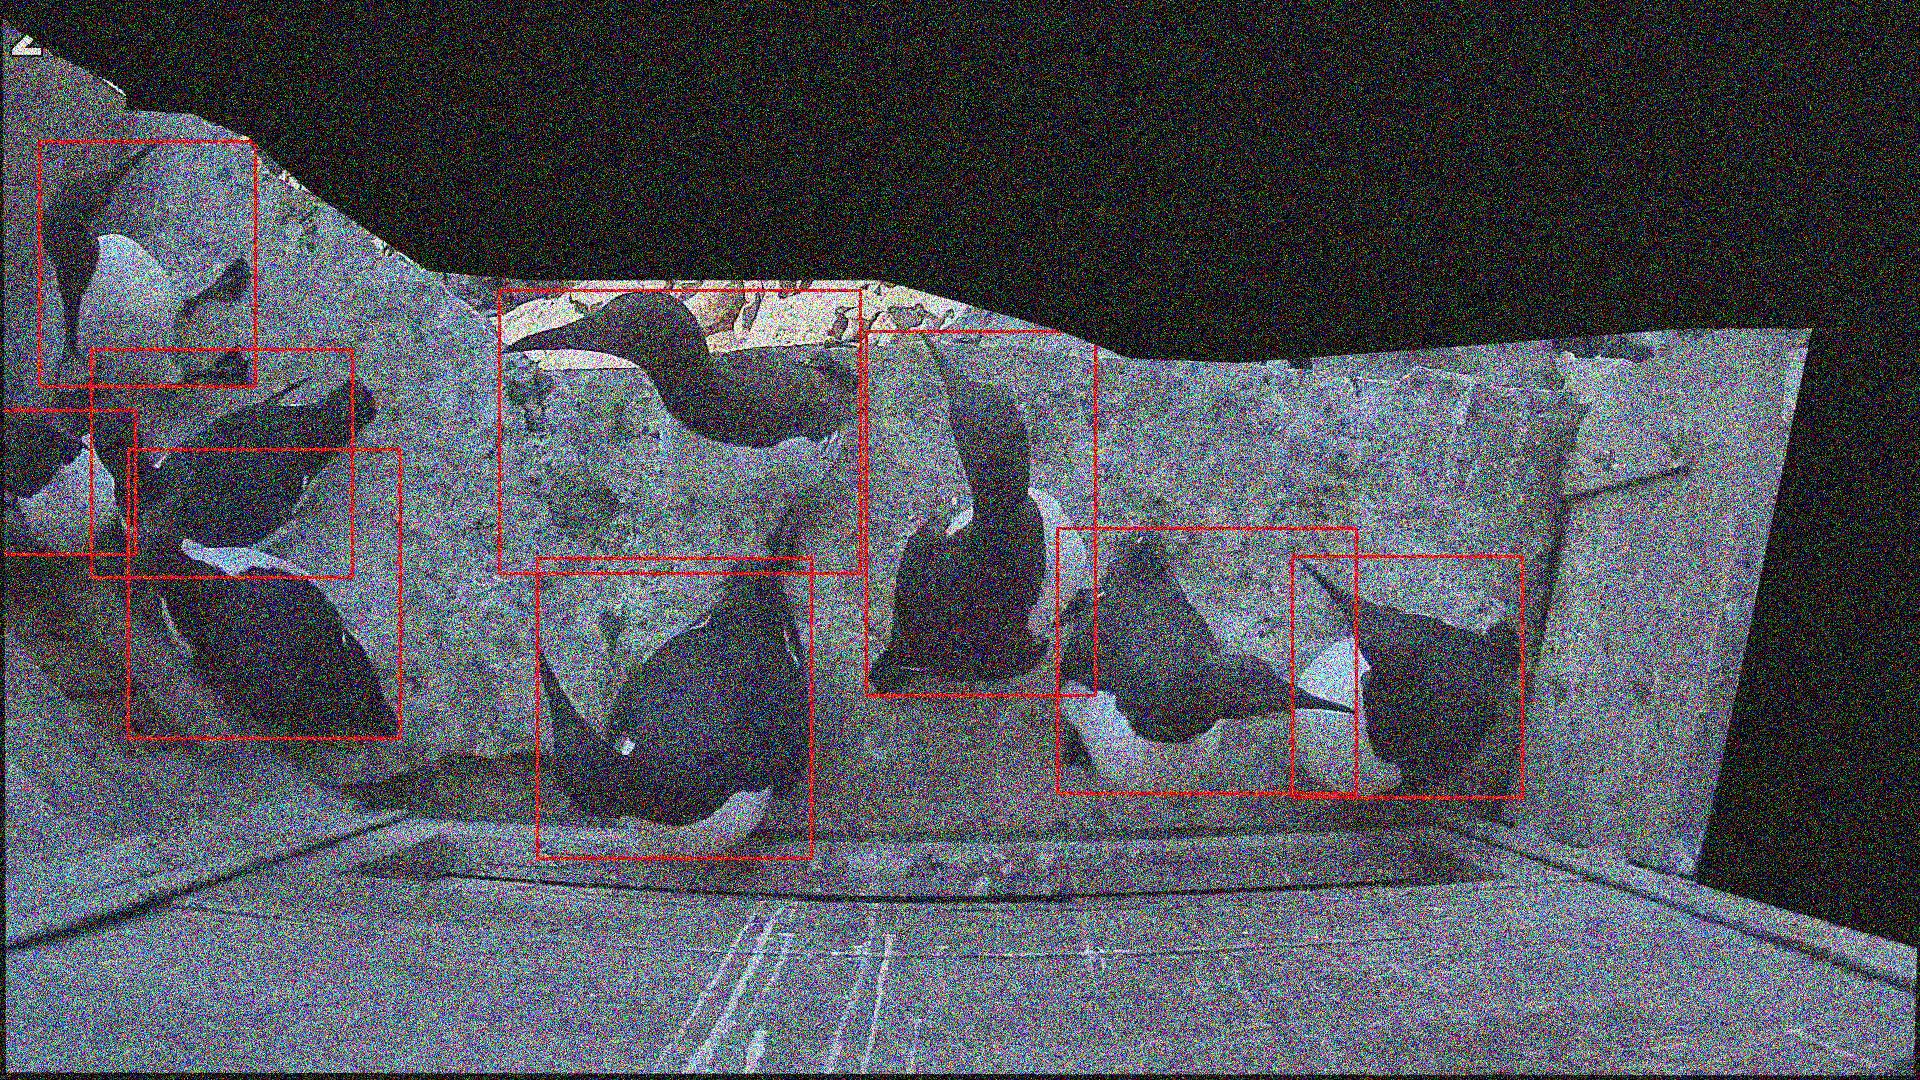

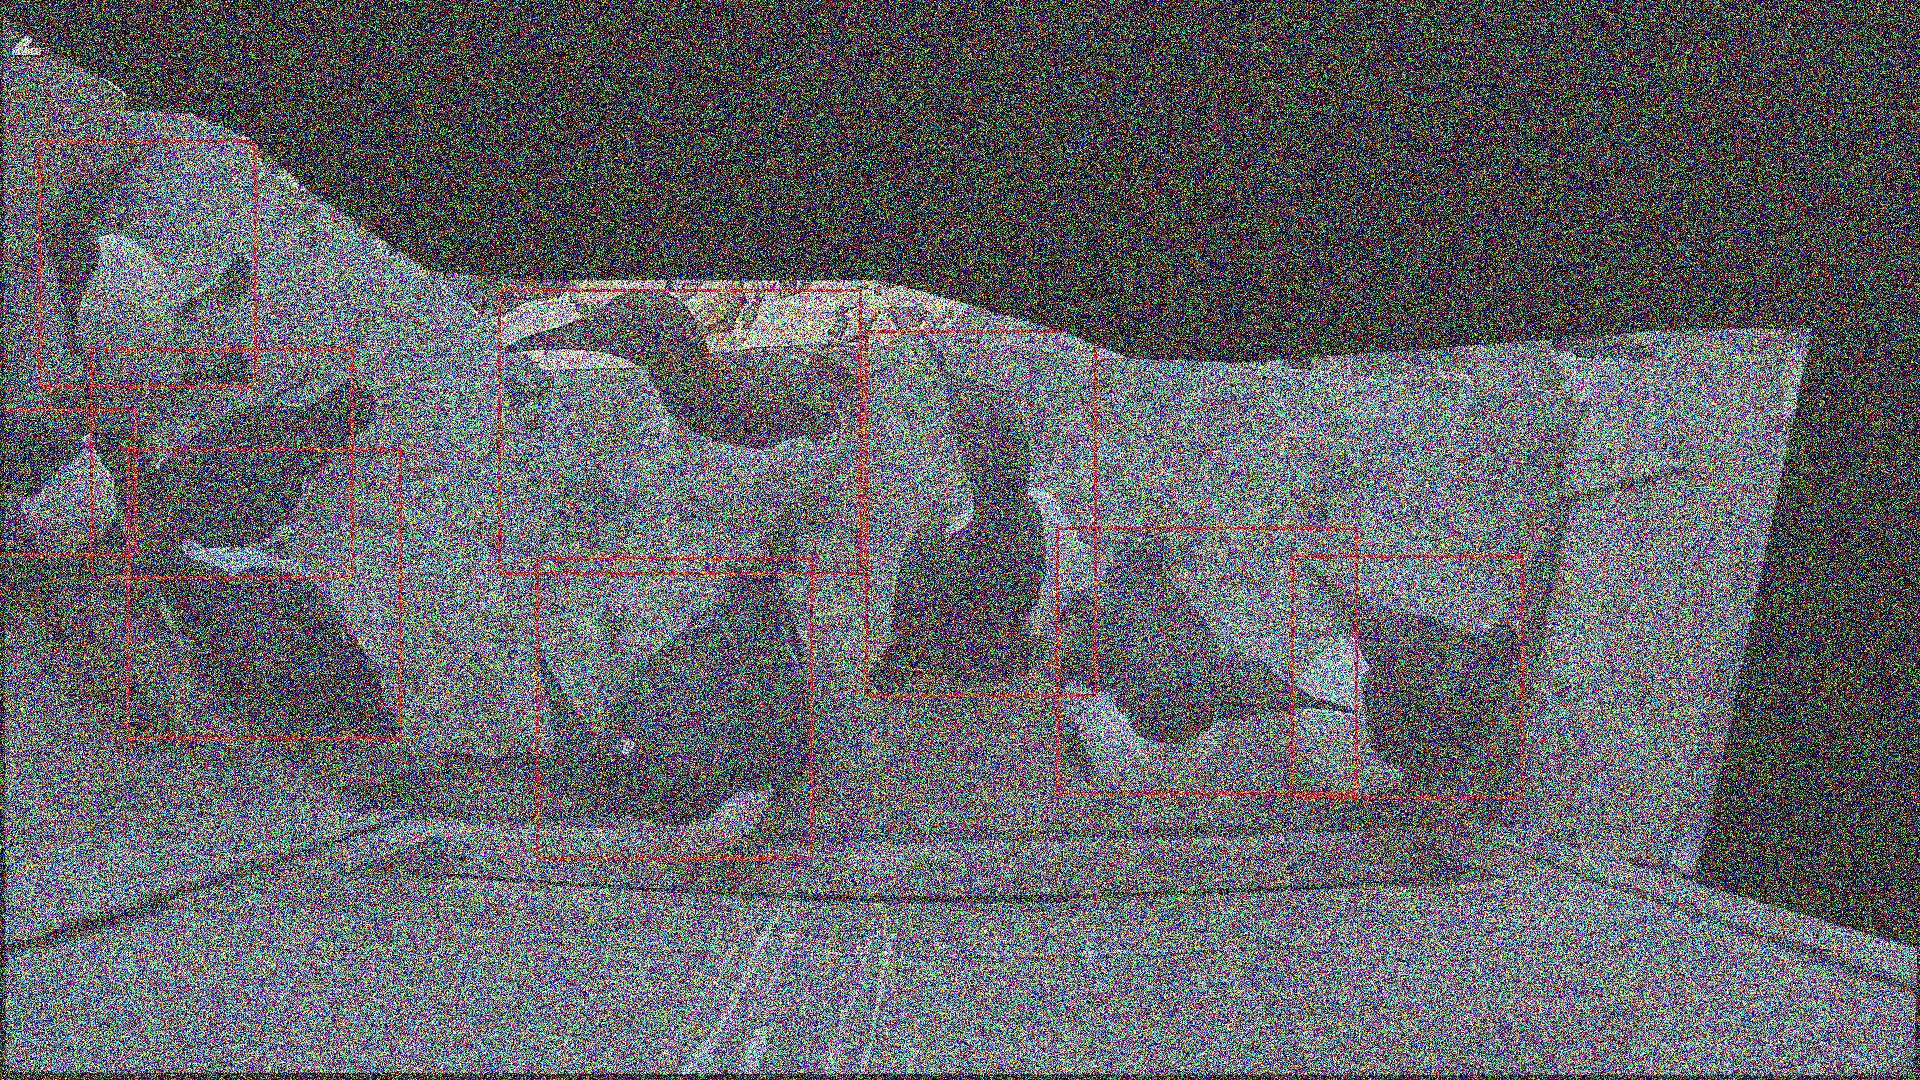

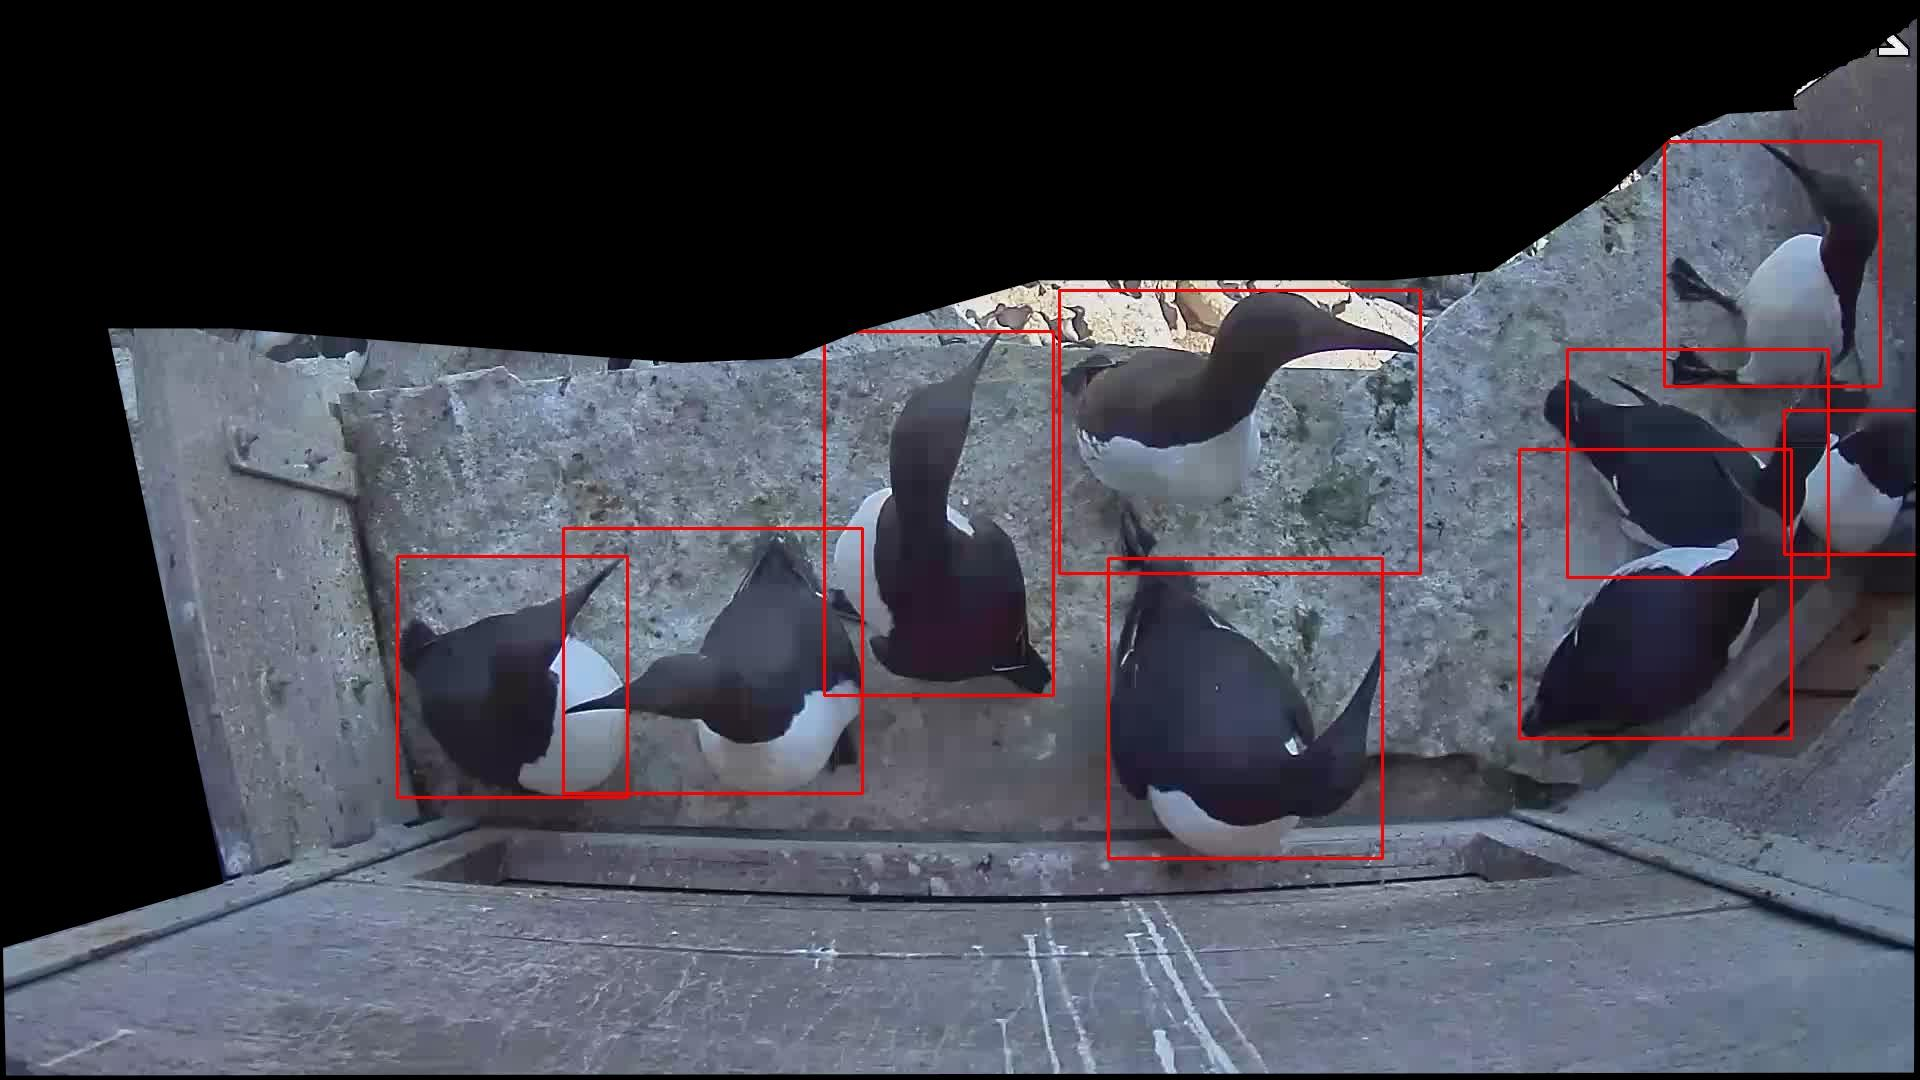

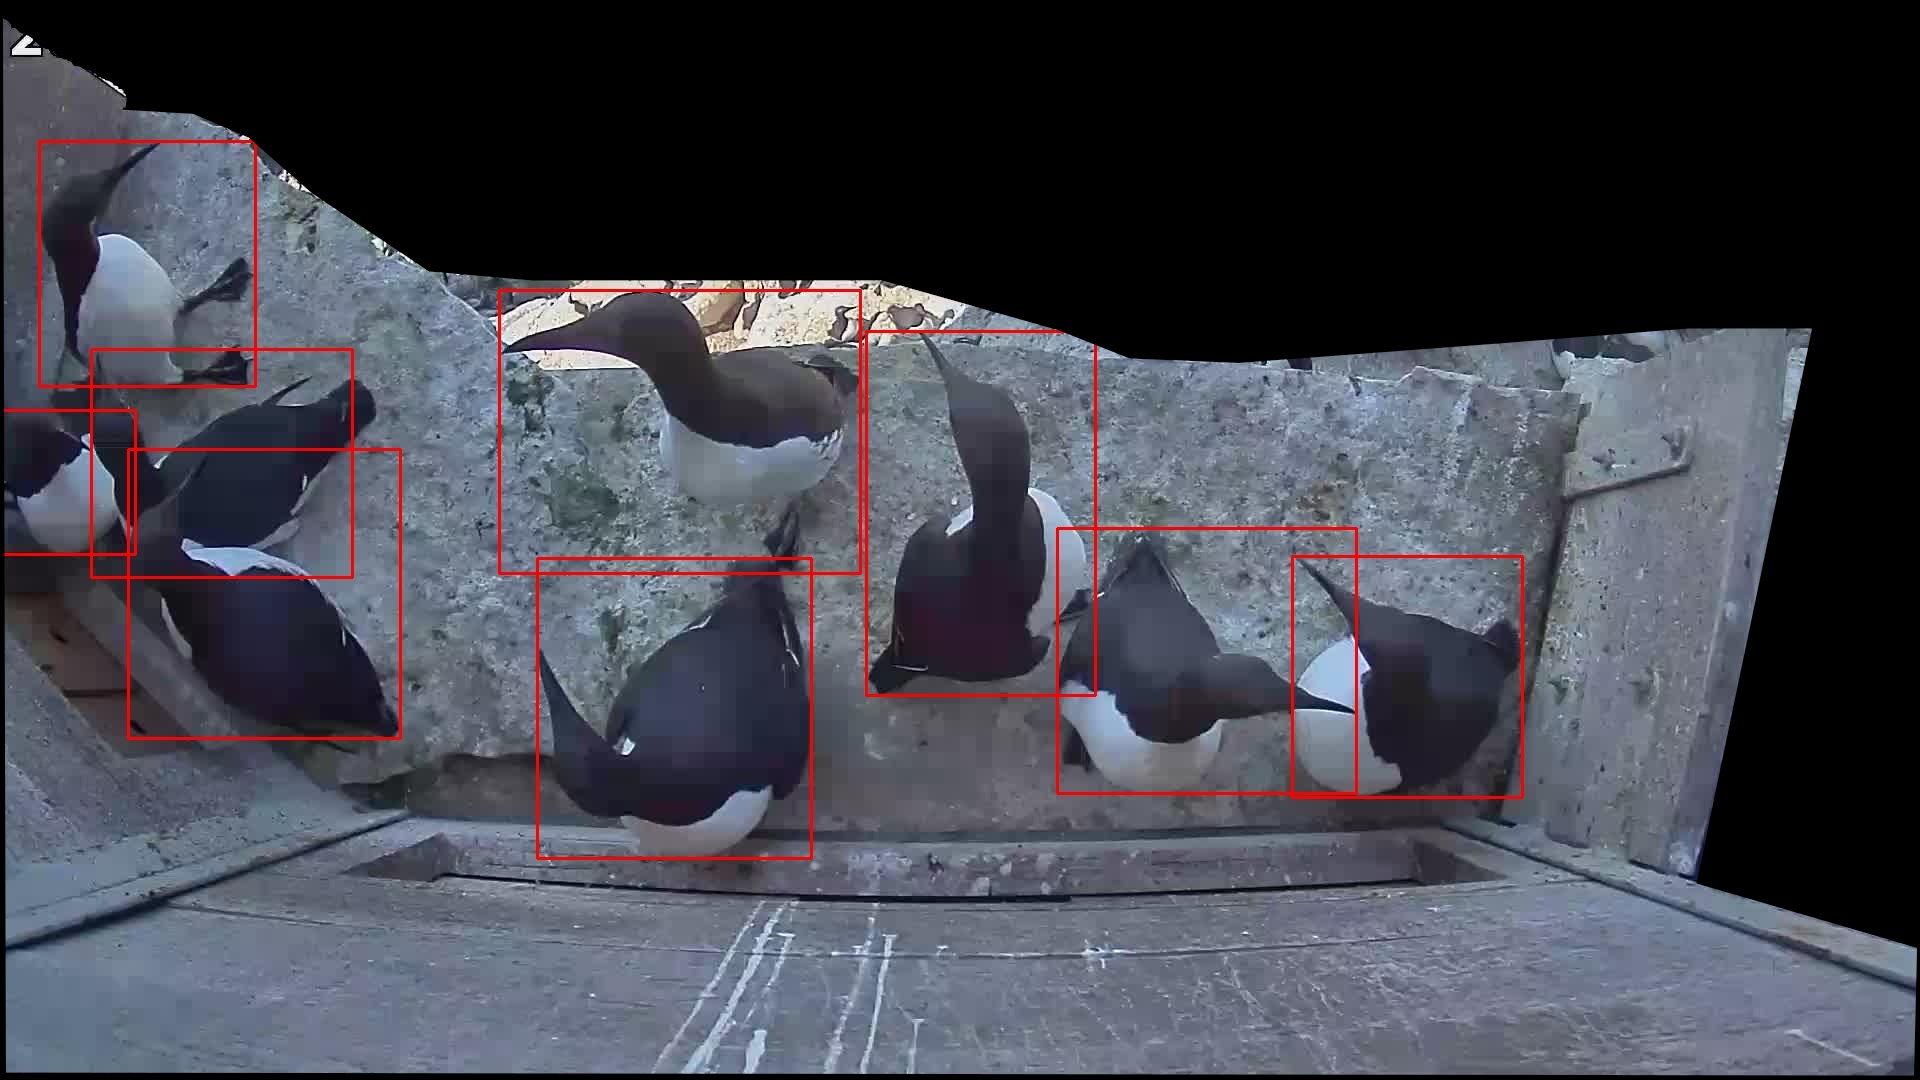

In [15]:
aug_data = '/data/demo/Annotation/image_augmentor/dir/*.jpg'

for image in glob.glob(aug_data):
    display(Image(filename=image, width=600, height=400))
 


In [ ]:
train = open("/data/demo/Annotation/train_new.txt",'r')
test = open("/data/demo/Annotation/test.txt",'r')

In [16]:
train_size = sum(1 for line in open("/data/demo/Annotation/train_new.txt",'r'))
train_size

3157

In [17]:
test_size = sum(1 for line in open("/data/demo/Annotation/test.txt",'r'))
test_size


1187